In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import tensorflow as tf

from deepsphere import HealpyGCNN
from deepsphere import healpy_layers as hp_layer
from deepsphere import utils

from tqdm import tqdm

2022-06-18 20:52:07.562085: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
import os

In [3]:
# import pyccl as ccl

# cosmo = ccl.Cosmology(Omega_c = 0.262, Omega_b = 0.048, h = 0.69, sigma8 = 0.83, n_s = 0.96)

# zs=np.linspace(0,1,100)
# dNdz = np.ones(zs.shape)
# bias = 1*np.ones(len(dNdz))

# clustering = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(zs,dNdz), bias=(zs,bias))
# ell = np.arange(0,6144)
# cls_clu = ccl.angular_cl(cosmo, clustering, clustering, ell) #Clustering

In [67]:
kSZMap = hp.read_map("./kSZ_NS_2048_R_2048_P_2560_DV_256.fits")
kSZMap2 = hp.read_map("./lensedkSZ_NS_1024_R_2968_P_2048_DV_80.fits")
kSZMap3 = np.load("./_NS_64_R_2968_P_192_DV_40_Sd_170351.npy")
kSZMap4 = np.load("./_NS_64_R_1484_P_256_DV_40_Sd_968694.npy")
kSZMap5 = np.load("./_NS_64_R_371_P_256_DV_40_Sd_868897.npy")
kSZMap6 = np.load("./_NS_64_R_2968_P_1024_DV_40_Sd_396025.npy")

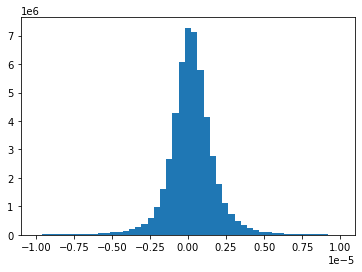

In [36]:
#2560^2 Particles
plt.hist(kSZMap, bins=np.linspace(-10**-5,10**-5));

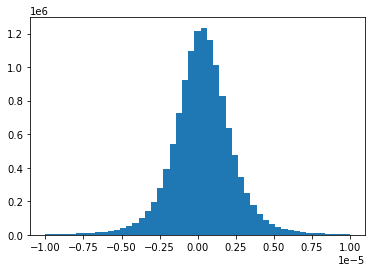

In [37]:
#2048^2 particles
plt.hist(kSZMap2, bins=np.linspace(-10**-5,10**-5));

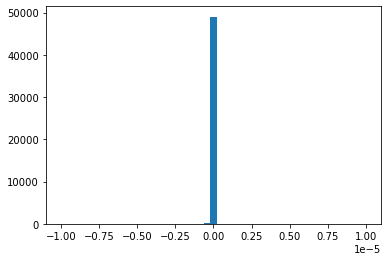

In [42]:
#192 particles, 
plt.hist(kSZMap3, bins=np.linspace(-10**-5,10**-5));

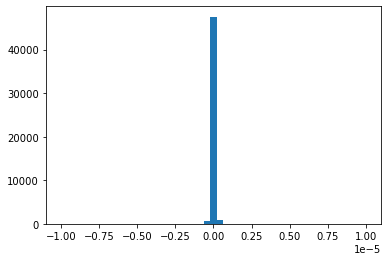

In [44]:
#256 particles, 
plt.hist(kSZMap4, bins=np.linspace(-10**-5,10**-5));

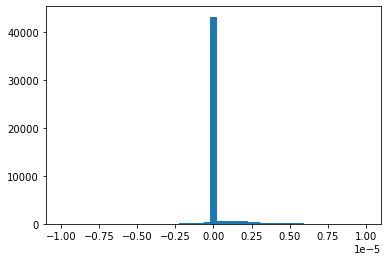

In [46]:
#256 particles, 
plt.hist(kSZMap5, bins=np.linspace(-10**-5,10**-5));

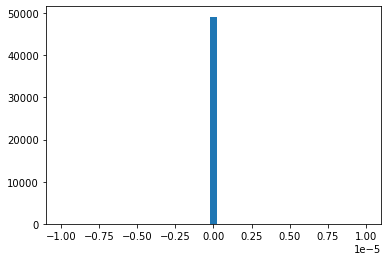

In [71]:
#1024 particles 
plt.hist(kSZMap6, bins=np.linspace(-10**-5,10**-5));

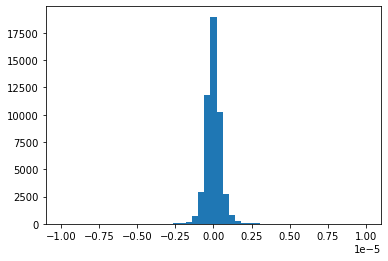

In [38]:
#192^2 particles
plt.hist(kSZData[2], bins=np.linspace(-10**-5,10**-5));

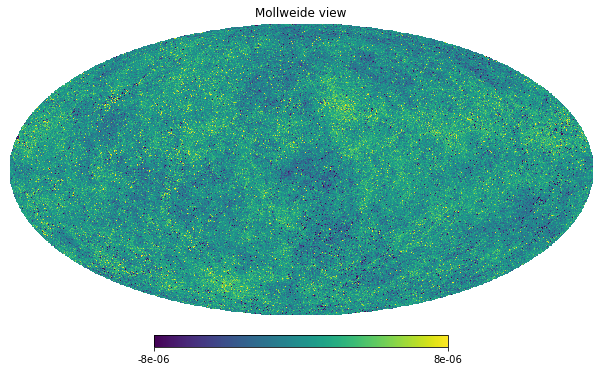

In [66]:
hp.mollview(kSZMap2,max=8*10**-6,min=-8*10**-6)

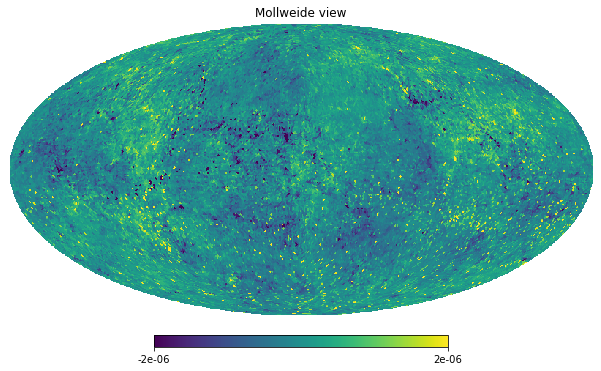

In [57]:
hp.mollview(kSZData[2],max=2*10**-6,min=-2*10**-6,nest=True)

In [13]:
kSZFiles = os.listdir('./Data/kSZ')
velFiles = os.listdir('./Data/velocityField')
densFiles = os.listdir('./Data/overdensity')

nside = 64
numSets=len(densFiles)

In [27]:
overdensData = np.zeros((numSets,12*nside**2))
kSZData = np.zeros((numSets,12*nside**2))
velData = np.zeros((numSets,12*nside**2))

In [28]:
for i in range(0,numSets):
    overdensData[i] = hp.reorder(np.load('./Data/overdensity/'+densFiles[i]),r2n=True)
#     overdensData[i] = 100*overdensData[i]/np.linalg.norm(overdensData[i])
    kSZData[i] = hp.reorder(np.load('./Data/kSZ/'+kSZFiles[i]),r2n=True)
#     kSZData[i] = 100*kSZData[i]/np.linalg.norm(kSZData[i])
    velData[i] = hp.reorder(np.load('./Data/velocityField/'+velFiles[i]),r2n=True)
#     velData[i] = 100*velData[i]/np.linalg.norm(velData[i])
# for i in range(0,numSets):
#     overdensData[i] = hp.reorder(hp.synfast(cls_clu,nside=nside),r2n=True)
#     kSZData[i] = hp.reorder(100000*hp.synfast(kSZPowSpec,nside=nside),r2n=True)
#     velData[i] = hp.reorder(kSZData[i]/(overdensData[i]+1),r2n=True)

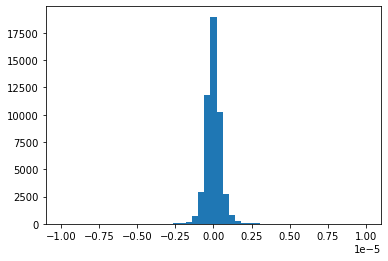

In [29]:
plt.hist(kSZData[2], bins=np.linspace(-10**-5,10**-5));

In [ ]:
#Make Fake CMB
h=0.69
pars = camb.CAMBparams()
pars.set_cosmology(H0=100.0*h, ombh2=0.048*h**2, omch2=0.262*h**2, mnu=0.06, omk=0)
pars.InitPower.set_params(As=2e-9, ns=0.96, r=0)
pars.set_for_lmax(6144, lens_potential_accuracy=0)
results = camb.get_results(pars)
powers =results.get_cmb_power_spectra(pars, CMB_unit='K')
l=np.arange(0,len(powers['total'][:,0]))
cambFactor = l*(l+1)/(2*np.pi)
CMB_camb = powers['total'][:,0]/cambFactor
CMB_camb[0]=0.0

In [ ]:
CMB_map = hp.sphtfunc.synfast(CMB_camb,nside=nside);

In [7]:
x_raw = np.stack((overdensData,kSZData),axis=2)
x_raw = np.reshape(x_raw,(numSets,12*nside**2,2))

x_train, x_test = np.split(x_raw, indices_or_sections=[numSets-numSets//20])
y_train, y_test = np.split(velData, indices_or_sections=[numSets-numSets//20])

In [8]:
dset_test = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_test),
                                 tf.data.Dataset.from_tensor_slices(y_test)))
dset_test = dset_test.shuffle(20)
dset_test = dset_test.batch(8)

dset_train = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train),
                                  tf.data.Dataset.from_tensor_slices(y_train)))
dset_train = dset_train.shuffle(200)
dset_train = dset_train.batch(8)

2022-06-03 20:52:12.162819: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-06-03 20:52:12.215609: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-06-03 20:52:12.215911: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-06-03 20:52:12.217716: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow 

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

dset_train = dset_train.prefetch(buffer_size=AUTOTUNE)
dset_test = dset_test.prefetch(buffer_size=AUTOTUNE)

/home/wurdahl/anaconda3/lib/python3.9/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_over(newcm(1.0))
/home/wurdahl/anaconda3/lib/python3.9/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_under(bgcolor)
/home/wurdahl/anaconda3/lib/python3.9/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. T

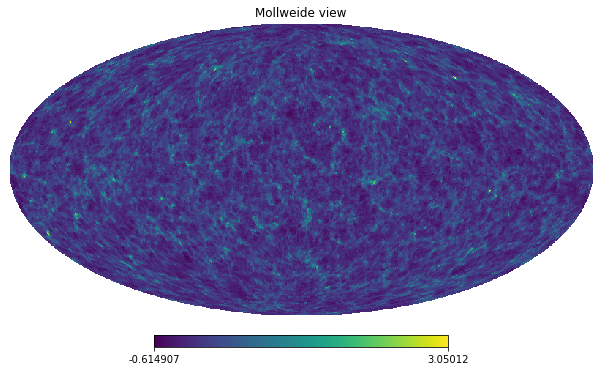

In [10]:
hp.mollview(overdensData[350],nest=True)

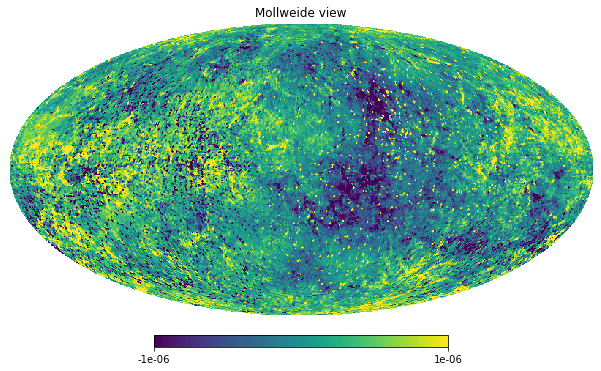

In [13]:
hp.mollview(kSZData[350],nest=True,max=10**-6,min=-10**-6)

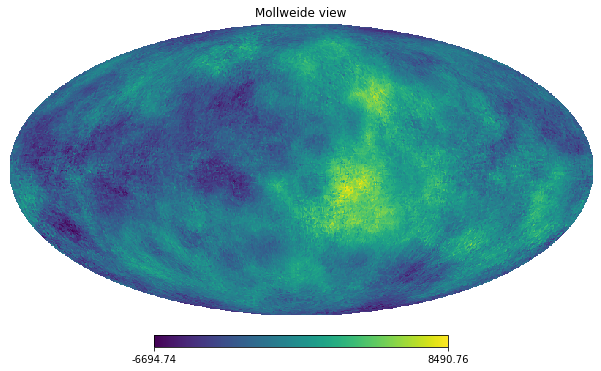

In [12]:
hp.mollview(velData[350],nest=True)

In [14]:
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [15]:
K = 5
layersBest = [#hp_layer.HealpyPseudoConv_Transpose(p=1, Fout=64, activation="linear"),
                  tf.keras.layers.BatchNormalization(),
                  hp_layer.HealpyChebyshev(K=K, Fout=64, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=32, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  #hp_layer.HealpyPseudoConv(p=1, Fout=32, activation="linear"),
                  #hp_layer.HealpyPseudoConv(p=1, Fout=16, activation="elu"),
                  #hp_layer.HealpyPseudoConv(p=1, Fout=32, activation="elu"),
                  hp_layer.HealpyChebyshev(K=K, Fout=32, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  tf.keras.layers.LayerNormalization(axis=1),
                  #hp_layer.HealpyPseudoConv(p=1, Fout=32, activation="linear"),
                  hp_layer.HealpyMonomial(K=K, Fout=32, use_bias=True, use_bn=False, 
                                           activation="linear"),
                  hp_layer.HealpyPseudoConv(p=1, Fout=32, activation="linear"),
                  #tf.keras.layers.BatchNormalization(),
                  hp_layer.HealpyChebyshev(K=K, Fout=32, use_bias=True, use_bn=False, 
                                   activation="linear"),
#                   hp_layer.HealpyChebyshev(K=K, Fout=32, use_bias=True, use_bn=False, 
#                                    activation="linear"),
                  #tf.keras.layers.LayerNormalization(axis=1),
                  hp_layer.HealpyChebyshev(K=K, Fout=32, use_bias=True, use_bn=False, 
                                           activation="linear"),
                  tf.keras.layers.LayerNormalization(axis=1),
                  #hp_layer.HealpyPool(p=1,pool_type='MAX'),
                  hp_layer.HealpyMonomial(K=K, Fout=32, use_bias=True, use_bn=False, 
                                           activation="linear"),
                  hp_layer.HealpyPseudoConv_Transpose(p=1, Fout=32, activation="linear"),
                  #tf.keras.layers.LayerNormalization(axis=1),
                  #hp_layer.HealpyPseudoConv_Transpose(p=1, Fout=16, activation="elu"),
                  #hp_layer.HealpyPseudoConv_Transpose(p=1, Fout=16, activation="elu"),
                  hp_layer.HealpyChebyshev(K=K, Fout=32, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  #tf.keras.layers.Dense(12*nside**2)
                  #hp_layer.HealpyPseudoConv_Transpose(p=1, Fout=24, activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=32, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=24, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=16, use_bias=True, use_bn=False, 
                                           activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=8, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=1, use_bias=True, use_bn=False, 
                                   activation="linear")
         ]

layersTest = [#hp_layer.HealpyPseudoConv_Transpose(p=1, Fout=64, activation="linear"),
                  tf.keras.layers.BatchNormalization(),
                  hp_layer.HealpyChebyshev(K=K, Fout=64, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=32, use_bias=True, use_bn=True, 
                                   activation="linear"),
                  #hp_layer.HealpyPseudoConv(p=1, Fout=32, activation="linear"),
                  #hp_layer.HealpyPseudoConv(p=1, Fout=16, activation="elu"),
                  #hp_layer.HealpyPseudoConv(p=1, Fout=32, activation="elu"),
                  hp_layer.HealpyChebyshev(K=K, Fout=32, use_bias=True, use_bn=True, 
                                   activation="linear"),
                  tf.keras.layers.LayerNormalization(axis=1),
                  #hp_layer.HealpyPseudoConv(p=1, Fout=32, activation="linear"),
                  hp_layer.HealpyMonomial(K=K, Fout=24, use_bias=True, use_bn=True, 
                                           activation="linear"),
                  hp_layer.HealpyPseudoConv(p=1, Fout=32, activation="linear"),
                  #tf.keras.layers.BatchNormalization(),
                  hp_layer.HealpyChebyshev(K=K, Fout=32, use_bias=True, use_bn=True, 
                                   activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=32, use_bias=True, use_bn=True, 
                                   activation="linear"),
                  #tf.keras.layers.LayerNormalization(axis=1),
                  hp_layer.HealpyChebyshev(K=K, Fout=32, use_bias=True, use_bn=True, 
                                           activation="linear"),
                  tf.keras.layers.LayerNormalization(axis=1),
                  #hp_layer.HealpyPool(p=1,pool_type='MAX'),
                  hp_layer.HealpyMonomial(K=K, Fout=32, use_bias=True, use_bn=True, 
                                           activation="linear"),
                  hp_layer.HealpyPseudoConv_Transpose(p=1, Fout=32, activation="linear"),
                  #tf.keras.layers.LayerNormalization(axis=1),
                  #hp_layer.HealpyPseudoConv_Transpose(p=1, Fout=16, activation="elu"),
                  #hp_layer.HealpyPseudoConv_Transpose(p=1, Fout=16, activation="elu"),
                  hp_layer.HealpyChebyshev(K=K, Fout=24, use_bias=True, use_bn=True, 
                                   activation="linear"),
                  #tf.keras.layers.Dense(12*nside**2)
                  #hp_layer.HealpyPseudoConv_Transpose(p=1, Fout=24, activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=24, use_bias=True, use_bn=True, 
                                   activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=24, use_bias=True, use_bn=True, 
                                   activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=16, use_bias=True, use_bn=True, 
                                           activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=8, use_bias=True, use_bn=True, 
                                   activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=1, use_bias=True, use_bn=True, 
                                   activation="linear")
         ]




In [16]:
#help(hp_layer.HealpyChebyshev)

In [17]:
n_pix = hp.nside2npix(nside)
indices = np.arange(n_pix)
modelHP = HealpyGCNN(nside=nside, layers=layersBest,indices=np.arange(0,12*nside**2), n_neighbors=40)
modelHP.build(input_shape=(None, len(indices), 2))
modelHP.summary(110)

Detected a reduction factor of 1.0, the input with nside 64 will be transformed to 64 during a forward pass. Checking for consistency with indices...
indices seem consistent...
Model: "healpy_gcnn_1"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 batch_normalization (BatchNormalization)        (None, 49152, 2)                            8                
                                                                                                              
 chebyshev (Chebyshev)                           (None, 49152, 64)                           704              
                                                                                                              
 chebyshev_1 (Chebyshev)                         (None, 49152, 32)                           10272            
                       

In [19]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

modelHP.compile(optimizer=opt,
              #loss=tf.keras.losses.Huber(delta=1.0,reduction="auto",name="huber_loss"),
                loss="MSE",
              metrics=[r_square]
)

checkpoint_filepath = './checkpoint'

# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath+"/{epoch}",
#     save_weights_only=False,
#     monitor='loss',
#     save_freq=3
# )
filePath = "./models/Model1_weights.{epoch:02d}.hdf5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=filePath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min')

In [20]:
initial_epochs = 10
history = modelHP.fit(
    dset_train,
    epochs=initial_epochs,
    validation_data = dset_test,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/10


2022-06-03 20:55:10.737102: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-06-03 20:55:11.370864: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400
2022-06-03 20:55:13.126644: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied


177/177 [==============================] - 201s 1s/step - loss: 4455060.0000 - r_square: -0.0151 - val_loss: 4547027.0000 - val_r_square: -0.0078
Epoch 2/10
177/177 [==============================] - 194s 1s/step - loss: 4426248.0000 - r_square: -0.0012 - val_loss: 4514209.5000 - val_r_square: 0.0116
Epoch 3/10
177/177 [==============================] - 195s 1s/step - loss: 4344200.5000 - r_square: 0.0170 - val_loss: 3199984.5000 - val_r_square: 0.2581
Epoch 4/10
177/177 [==============================] - 195s 1s/step - loss: 2339769.0000 - r_square: 0.4729 - val_loss: 2254325.5000 - val_r_square: 0.4702
Epoch 5/10
177/177 [==============================] - 195s 1s/step - loss: 2137636.2500 - r_square: 0.5198 - val_loss: 2232018.5000 - val_r_square: 0.5071
Epoch 6/10
177/177 [==============================] - 195s 1s/step - loss: 2114132.2500 - r_square: 0.5290 - val_loss: 2218460.5000 - val_r_square: 0.5035
Epoch 7/10
177/177 [==============================] - 195s 1s/step - loss: 209

In [21]:
fine_tune_epochs = 2
total_epochs =  initial_epochs + fine_tune_epochs

history_further = modelHP.fit(dset_train,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=dset_test)

Epoch 10/12
177/177 [==============================] - 195s 1s/step - loss: 1945136.1250 - r_square: 0.5650 - val_loss: 2371053.5000 - val_r_square: 0.5076
Epoch 11/12
177/177 [==============================] - 195s 1s/step - loss: 1750159.7500 - r_square: 0.6088 - val_loss: 2424637.7500 - val_r_square: 0.4759
Epoch 12/12
177/177 [==============================] - 194s 1s/step - loss: 1502733.3750 - r_square: 0.6614 - val_loss: 2997221.5000 - val_r_square: 0.3576


In [22]:
total_epochs =  initial_epochs + fine_tune_epochs+1

history_furthest = modelHP.fit(dset_train,
                         epochs=total_epochs,
                         initial_epoch=history_further.epoch[-1],
                         validation_data=dset_test)

Epoch 12/13
177/177 [==============================] - 195s 1s/step - loss: 1269861.1250 - r_square: 0.7099 - val_loss: 2742601.2500 - val_r_square: 0.3871
Epoch 13/13
177/177 [==============================] - 195s 1s/step - loss: 1107874.1250 - r_square: 0.7464 - val_loss: 2709656.5000 - val_r_square: 0.3971


In [23]:
total_epochs =  initial_epochs + fine_tune_epochs+1+1

history_furthester = modelHP.fit(dset_train,
                         epochs=total_epochs,
                         initial_epoch=history_furthest.epoch[-1],
                         validation_data=dset_test)

Epoch 13/14
177/177 [==============================] - 195s 1s/step - loss: 1003034.1875 - r_square: 0.7708 - val_loss: 2981258.5000 - val_r_square: 0.3459
Epoch 14/14
177/177 [==============================] - 194s 1s/step - loss: 942393.5000 - r_square: 0.7827 - val_loss: 3067924.0000 - val_r_square: 0.3119


In [ ]:
#modelHP.save('SavedModels/BestModelSoFar/')

In [33]:
reconst = np.reshape(modelHP(x_train[10:11],True).numpy(),(12*nside**2))
goal = np.reshape(y_train[10:11],(12*nside**2))

/home/wurdahl/anaconda3/lib/python3.9/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_over(newcm(1.0))
/home/wurdahl/anaconda3/lib/python3.9/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_under(bgcolor)
/home/wurdahl/anaconda3/lib/python3.9/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. T

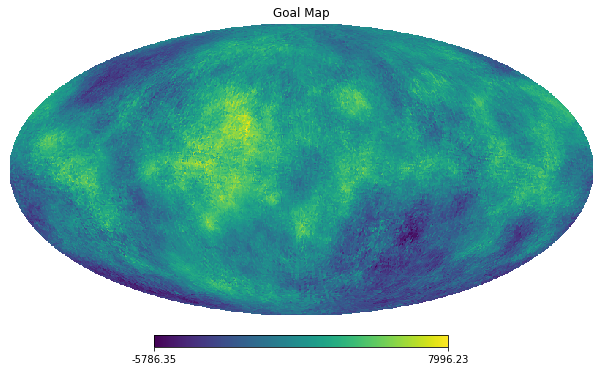

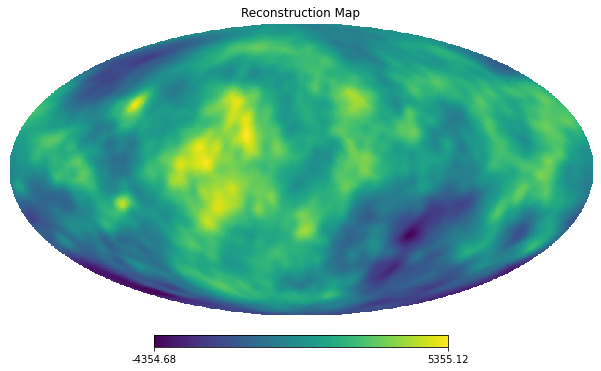

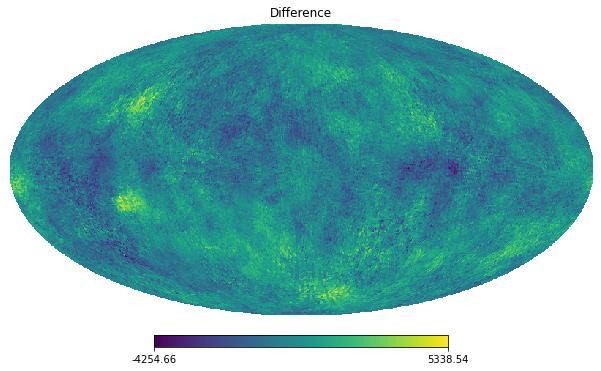

In [34]:
hp.mollview(goal, nest=True, title="Goal Map");
hp.mollview(reconst, nest=True, title="Reconstruction Map");
hp.mollview(reconst - goal, nest=True, title="Difference");

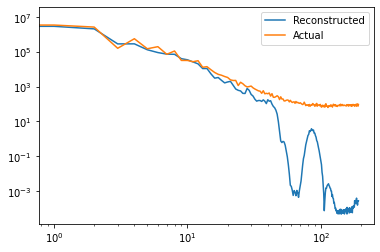

In [35]:
reconst = hp.reorder(reconst,n2r=True)
goal = hp.reorder(goal,n2r=True)
plt.loglog(hp.anafast(reconst))
plt.loglog(hp.anafast(goal))
plt.legend(["Reconstructed","Actual"])

In [36]:
correlation = hp.anafast(reconst,goal)/np.sqrt(hp.anafast(goal)*hp.anafast(reconst)) 

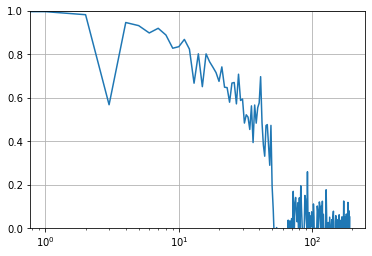

In [37]:
plt.semilogx(correlation);
plt.grid()
plt.ylim([0, 1]);

In [38]:
np.mean(correlation)

0.17257136354201108

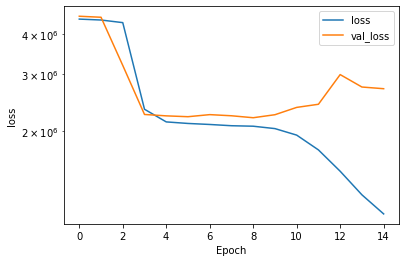

In [39]:
plt.semilogy(np.concatenate((history.history['loss'],history_further.history['loss'],history_furthest.history['loss'])), label='loss');
plt.semilogy(np.concatenate((history.history['val_loss'],history_further.history['val_loss'],history_furthest.history['val_loss'])), label = 'val_loss');
plt.xlabel('Epoch')
plt.ylabel('loss')
#plt.ylim([0.5, 1])
plt.legend(loc='upper right');

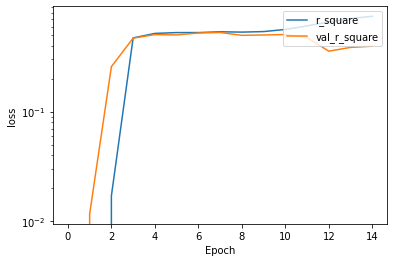

In [41]:
plt.semilogy(np.append(np.append(history.history['r_square'],history_further.history['r_square']),history_furthest.history['r_square']), label='r_square')
plt.semilogy(np.append(np.append(history.history['val_r_square'],history_further.history['val_r_square']),history_furthest.history['val_r_square']), label = 'val_r_square')
plt.xlabel('Epoch')
plt.ylabel('loss')
#plt.ylim([0.5, 1])
plt.legend(loc='upper right')

# Correlation of all samples

In [42]:
reconstAll = np.reshape(modelHP(x_train,False).numpy(),(12*nside**2))
goal = np.reshape(y_train,(12*nside**2))

2022-06-03 21:52:16.095216: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.03GiB (rounded to 1109655552)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-06-03 21:52:16.095469: I tensorflow/core/common_runtime/bfc_allocator.cc:1027] BFCAllocator dump for GPU_0_bfc
2022-06-03 21:52:16.095497: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (256): 	Total Chunks: 132, Chunks in use: 131. 33.0KiB allocated for chunks. 32.8KiB in use in bin. 6.1KiB client-requested in use in bin.
2022-06-03 21:52:16.095503: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (512): 	Total Chunks: 1, Chunks in use: 0. 768B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2022-06-03 21:52:16.095506: I tensorflo

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

9655552 next 8
2022-06-03 21:52:16.096267: I tensorflow/core/common_runtime/bfc_allocator.cc:1083] InUse at 659a80900 of size 554827776 next 9
2022-06-03 21:52:16.096269: I tensorflow/core/common_runtime/bfc_allocator.cc:1083] InUse at 67aba0900 of size 256 next 10
2022-06-03 21:52:16.096271: I tensorflow/core/common_runtime/bfc_allocator.cc:1083] InUse at 67aba0a00 of size 256 next 11
2022-06-03 21:52:16.096273: I tensorflow/core/common_runtime/bfc_allocator.cc:1083] InUse at 67aba0b00 of size 256 next 34
2022-06-03 21:52:16.096275: I tensorflow/core/common_runtime/bfc_allocator.cc:1083] InUse at 67aba0c00 of size 256 next 38
2022-06-03 21:52:16.096277: I tensorflow/core/common_runtime/bfc_allocator.cc:1083] InUse at 67aba0d00 of size 256 next 43
2022-06-03 21:52:16.096279: I tensorflow/core/common_runtime/bfc_allocator.cc:1083] InUse at 67aba0e00 of size 256 next 46
2022-06-03 21:52:16.096281: I tensorflow/core/common_runtime/bfc_allocator.cc:1083] InUse at 67aba0f00 of size 256 next

In [ ]:
modelHP(x_train[0:5])

In [43]:
modelHP.save("./SavedModels/R2.81/")

INFO:tensorflow:Assets written to: ./SavedModels/R2.81/assets


INFO:tensorflow:Assets written to: ./SavedModels/R2.81/assets
